<a href="https://colab.research.google.com/github/NawshinNeaha/Dengu/blob/main/Dengu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19 # etc.
import albumentations as A
import cv2
import os
import glob
from tqdm.notebook import tqdm
import numpy as np
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# -------------------------------------------------------------
# 1. CONFIGURATION AND PATH SETUP
# -------------------------------------------------------------
global NUM_CLASSES, IMAGE_SIZE, TRAIN_DATA_ROOT, VALID_FIXED_DIR, TEST_FIXED_DIR
NUM_CLASSES = 3
IMAGE_SIZE = 224
NUM_AUGMENTATIONS_PER_IMAGE = 25 # Training Augmentation Level
NUM_AUGMENTATIONS_PER_IMAGE_TEST = 5 # CRITICAL: Test Augmentation Level
CLASS_NAMES = ['ClassA', 'ClassB', 'ClassC']

BASE_DIR = "/content/drive/MyDrive/yolo/MosquitoFusion Dataset"

# Fixed Output Paths
TRAIN_DATA_ROOT = "/content/working/train_augmented_final"
VALID_FIXED_DIR = "/content/working/valid_fixed"
TEST_FIXED_DIR = "/content/working/test_fixed_augmented" # Renaming test output for clarity

# Global variables that generators will use
TRAIN_DATA_DIR = TRAIN_DATA_ROOT
VALID_DATA_DIR = VALID_FIXED_DIR
TEST_DATA_DIR = TEST_FIXED_DIR

# Input Paths (Original dataset structure)
INPUT_TRAIN_IMAGE_DIR = os.path.join(BASE_DIR, "train", "images")
INPUT_TRAIN_LABEL_DIR = os.path.join(BASE_DIR, "train", "labels")
INPUT_VALID_IMAGE_DIR = os.path.join(BASE_DIR, "valid", "images")
INPUT_VALID_LABEL_DIR = os.path.join(BASE_DIR, "valid", "labels")
INPUT_TEST_IMAGE_DIR = os.path.join(BASE_DIR, "test", "images")
INPUT_TEST_LABEL_DIR = os.path.join(BASE_DIR, "test", "labels")

# Clean old folders
for path in [TRAIN_DATA_ROOT, VALID_FIXED_DIR, TEST_FIXED_DIR]:
    if os.path.exists(path):
        shutil.rmtree(path)
        print(f"Old folder cleaned: {path}")

# ======================================================================
# ২. ডেটা ফিক্সিং এবং অগমেন্টেশন ফাংশন (CRITICAL LOGIC)
# ======================================================================

def get_class_map_from_labels(label_dir):
    """Parses YOLO-style labels (first number = class index) to map images to classes."""
    img_to_class = {}
    label_files = glob.glob(os.path.join(label_dir, "*.txt"))
    for label_file in label_files:
        try:
            with open(label_file, 'r') as f:
                content = f.readline().strip()
                if content: # Check if line is not empty
                    class_index = int(content.split(' ')[0])
                    if 0 <= class_index < NUM_CLASSES:
                        img_name_base = os.path.splitext(os.path.basename(label_file))[0]
                        img_to_class[img_name_base] = CLASS_NAMES[class_index]
        except Exception as e:
            print(f"Error processing label file {label_file}: {e}")
            continue
    return img_to_class

def copy_and_augment(input_img_dir, class_map, output_fixed_dir, desc, num_augmentations, augment_pipeline):
    """Copies original image and creates augmented copies (if num_augmentations > 0)."""
    img_count = 0
    for base_name, img_class in tqdm(class_map.items(), desc=desc):
        img_path_jpg = os.path.join(input_img_dir, base_name + '.jpg')
        img_path_png = os.path.join(input_img_dir, base_name + '.png')
        img_source = None
        if os.path.exists(img_path_jpg):
            img_source = img_path_jpg
        elif os.path.exists(img_path_png):
            img_source = img_path_png

        if img_source:
            output_class_dir = os.path.join(output_fixed_dir, img_class)
            os.makedirs(output_class_dir, exist_ok=True) # Ensure class directory exists

            image = cv2.cvtColor(cv2.imread(img_source), cv2.COLOR_BGR2RGB)

            # Save original copy
            shutil.copy(img_source, os.path.join(output_class_dir, os.path.basename(img_source)))
            img_count += 1

            # Save augmented copies if requested
            if num_augmentations > 0:
                for i in range(num_augmentations):
                    augmented = augment_pipeline(image=image)
                    new_filename = f"{base_name}_aug_{i}.jpg"
                    save_path = os.path.join(output_class_dir, new_filename)
                    cv2.imwrite(save_path, cv2.cvtColor(augmented['image'], cv2.COLOR_RGB2BGR))
                    img_count += 1
    return img_count


def run_data_processing():
    """Runs Augmentation for Training and Restructures Valid/Test data."""

    print("\n--- Starting Data Processing ---")

    # 3.1 Get Class Maps and Setup Folders
    train_class_map = get_class_map_from_labels(INPUT_TRAIN_LABEL_DIR)
    valid_class_map = get_class_map_from_labels(INPUT_VALID_LABEL_DIR)
    test_class_map = get_class_map_from_labels(INPUT_TEST_LABEL_DIR)

    for path in [TRAIN_DATA_ROOT, VALID_FIXED_DIR, TEST_FIXED_DIR]:
        for class_name in CLASS_NAMES:
            os.makedirs(os.path.join(path, class_name), exist_ok=True)
            print(f"Ensured directory exists: {os.path.join(path, class_name)}") # Added print statement


    # 3.2 Augmentation Pipeline (for all data)
    augment_pipeline = A.Compose([
        A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, interpolation=cv2.INTER_LINEAR, p=1.0),
        A.HorizontalFlip(p=0.5), A.Rotate(limit=15, border_mode=cv2.BORDER_CONSTANT, p=0.6),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5), A.GaussNoise(p=0.1),
    ])

    # 3.3 Process Training Data (Augment and Save)
    train_img_paths = [os.path.join(INPUT_TRAIN_IMAGE_DIR, f + ext) for f in train_class_map.keys() for ext in ['.jpg', '.png'] if os.path.exists(os.path.join(INPUT_TRAIN_IMAGE_DIR, f + ext))]

    print(f"Found {len(train_img_paths)} training images to process.")

    for img_path in tqdm(train_img_paths, desc="1. Augmenting Training Images"):
        base_name_no_ext = os.path.splitext(os.path.basename(img_path))[0]
        img_class = train_class_map.get(base_name_no_ext)
        if img_class: # Ensure class is found
            output_class_dir = os.path.join(TRAIN_DATA_ROOT, img_class)
            os.makedirs(output_class_dir, exist_ok=True) # Ensure class directory exists
            image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

            # Save NUM_AUGMENTATIONS_PER_IMAGE copies for training
            for i in range(NUM_AUGMENTATIONS_PER_IMAGE):
                augmented = augment_pipeline(image=image)
                new_filename = f"{base_name_no_ext}_aug_{i}.jpg"
                save_path = os.path.join(output_class_dir, new_filename)
                cv2.imwrite(save_path, cv2.cvtColor(augmented['image'], cv2.COLOR_RGB2BGR))
        else:
            print(f"Warning: Class not found for training image {img_path}. Skipping.")


    print(f"✅ Training Data Fix & Augmentation Complete.")

    # 3.4 Process Validation and Test Data (CRITICAL FIX: Augment Test, Not Validation)

    # 2. Validation Data (NO AUGMENTATION - num_augmentations=0)
    valid_count = copy_and_augment(INPUT_VALID_IMAGE_DIR, valid_class_map, VALID_FIXED_DIR,
                                   "2. Copying Validation Data (Original)", 0, augment_pipeline)

    # 3. Test Data (AUGMENTATION APPLIED - num_augmentations=NUM_AUGMENTATIONS_PER_IMAGE_TEST)
    test_count = copy_and_augment(INPUT_TEST_IMAGE_DIR, test_class_map, TEST_FIXED_DIR,
                                  "3. Augmenting Test Data (Fixing Low Count)", NUM_AUGMENTATIONS_PER_IMAGE_TEST, augment_pipeline)

    print(f"✅ Validation Data Fixed (Originals): {valid_count} images. Test Data Augmented: {test_count} images.")

# --- RUN THE DATA PROCESSING ---
run_data_processing()

Old folder cleaned: /content/working/train_augmented_final
Old folder cleaned: /content/working/valid_fixed
Old folder cleaned: /content/working/test_fixed_augmented

--- Starting Data Processing ---
Found 1053 training images to process.


1. Augmenting Training Images:   0%|          | 0/1053 [00:00<?, ?it/s]

✅ Training Data Fix & Augmentation Complete.


2. Copying Validation Data (Original):   0%|          | 0/100 [00:00<?, ?it/s]

3. Augmenting Test Data (Fixing Low Count):   0%|          | 0/51 [00:00<?, ?it/s]

✅ Validation Data Fixed (Originals): 100 images. Test Data Augmented: 306 images.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os

# --- GLOBAL VARIABLES ---
NUM_CLASSES = 3
IMAGE_SIZE = 224
BATCH_SIZE = 32
TRAIN_DATA_DIR = "/content/working/train_augmented_final"
VALID_DATA_DIR = "/content/working/valid_fixed"
TEST_DATA_DIR = "/content/working/test_fixed_augmented"
# ------------------------

# -------------------------------------------------------------
# 1. MODEL CONFIGURATION
# -------------------------------------------------------------
model_name = "NASNetMobile_AUG_TEST"
team_member = "Neha"
base_model_class = tf.keras.applications.NASNetMobile
preprocess_input = tf.keras.applications.nasnet.preprocess_input

print(f"\n--- Starting Setup for {model_name} by {team_member} ---")

# -------------------------------------------------------------
# 2. DATA GENERATORS
# -------------------------------------------------------------
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

try:
    train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
    validation_generator = valid_datagen.flow_from_directory(VALID_DATA_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
    test_generator = test_datagen.flow_from_directory(TEST_DATA_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

    print(f"Found {train_generator.samples} training images belonging to {train_generator.num_classes} classes.")
    print(f"Found {validation_generator.samples} validation images belonging to {validation_generator.num_classes} classes.")
    print(f"Found {test_generator.samples} test images belonging to {test_generator.num_classes} classes.")

except Exception as e:
    print(f"Error creating data generators: {e}")


--- Starting Setup for NASNetMobile_AUG_TEST by Neha ---
Found 26325 images belonging to 3 classes.
Found 100 images belonging to 3 classes.
Found 306 images belonging to 3 classes.
Found 26325 training images belonging to 3 classes.
Found 100 validation images belonging to 3 classes.
Found 306 test images belonging to 3 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# --- GLOBAL VARIABLES (ensure these match your setup) ---
IMAGE_SIZE = 224
BATCH_SIZE = 32
TRAIN_DATA_DIR = "/content/working/train_augmented_final"
VALID_DATA_DIR = "/content/working/valid_fixed"
TEST_DATA_DIR = "/content/working/test_fixed_augmented"
# ------------------------

# -------------------------------------------------------------
# 2. DATA GENERATORS
# -------------------------------------------------------------
# Assuming preprocess_input is defined elsewhere or is not needed for your model's base
# If your base model requires a specific preprocessing function (like NASNetMobile),
# make sure it's imported and used here.
# Example for NASNetMobile: from tensorflow.keras.applications.nasnet import preprocess_input
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
# valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
# test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

# Using a generic ImageDataGenerator if no specific preprocessing is required by the model
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()


try:
    train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
    validation_generator = valid_datagen.flow_from_directory(VALID_DATA_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
    test_generator = test_datagen.flow_from_directory(TEST_DATA_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

    print(f"Found {train_generator.samples} training images belonging to {train_generator.num_classes} classes.")
    print(f"Found {validation_generator.samples} validation images belonging to {validation_generator.num_classes} classes.")
    print(f"Found {test_generator.samples} test images belonging to {test_generator.num_classes} classes.")

except Exception as e:
    print(f"Error creating data generators: {e}")

Error creating data generators: [Errno 2] No such file or directory: '/content/working/train_augmented_final'


In [ ]:
# 3. MODEL BUILDING
base_model = base_model_class(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x) # Add Global Average Pooling layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x) # Add output layer

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv1 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn1            │ (None, 111, 111,  │        128 │ stem_conv1[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_376      │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_conv_1_s… │ (None, 111, 111,  │        352 │ activation_376[0… │
│ (Conv2D)            │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_bn_1_ste… │ (None, 111, 111,  │         44 │ reduction_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_377      │ (None, 111, 111,  │          0 │ reduction_bn_1_s… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_379      │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 115, 115,  │          0 │ activation_377[0… │
│ (ZeroPadding2D)     │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 117, 117,  │          0 │ activation_379[0… │
│ (ZeroPadding2D)     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │        396 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │      1,920 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_378      │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_380      │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_2_r… │ (None, 56, 56,    │        396 │ activation_378[0

 Total params: 4,272,887 (16.30 MB)

 Trainable params: 3,171 (12.39 KB)

 Non-trainable params: 4,269,716 (16.29 MB)

In [ ]:
# 5. Evaluate the model
print("\n--- Evaluating Model ---")

# Evaluate on Training Data
train_loss, train_acc = model.evaluate(train_generator)
print(f"Training Accuracy: {train_acc*100:.2f}%")
print(f"Training Loss: {train_loss:.4f}")

# Evaluate on Test Data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions for the test set
test_generator.reset() # Reset the generator to ensure predictions are in order
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Generate classification report
class_names = list(test_generator.class_indices.keys()) # Get class names from the generator
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


--- Evaluating Model ---


NameError: name 'train_generator' is not defined

In [ ]:
# --- GLOBAL VARIABLES (ensure these match your setup) ---
IMAGE_SIZE = 224
BATCH_SIZE = 32
TRAIN_DATA_DIR = "/content/working/train_augmented_final"
VALID_DATA_DIR = "/content/working/valid_fixed"
TEST_DATA_DIR = "/content/working/test_fixed_augmented"
# ------------------------

# 2. DATA GENERATORS
from tensorflow.keras.applications.nasnet import preprocess_input

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)


try:
    train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
    validation_generator = valid_datagen.flow_from_directory(VALID_DATA_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
    test_generator = test_datagen.flow_from_directory(TEST_DATA_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

    print(f"Found {train_generator.samples} training images belonging to {train_generator.num_classes} classes.")
    print(f"Found {validation_generator.samples} validation images belonging to {validation_generator.num_classes} classes.")
    print(f"Found {test_generator.samples} test images belonging to {test_generator.num_classes} classes.")

except Exception as e:
    print(f"Error creating data generators: {e}")

Error creating data generators: [Errno 2] No such file or directory: '/content/working/train_augmented_final'


In [ ]:
import os

train_dir = '/content/drive/MyDrive/yolo/MosquitoFusion Dataset/train'

if os.path.exists(train_dir):
    print(f"The directory '{train_dir}' exists.")
else:
    print(f"The directory '{train_dir}' does not exist.")

The directory '/content/drive/MyDrive/yolo/MosquitoFusion Dataset/train' exists.


In [ ]:
# 3. MODEL BUILDING (ResNet Example)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Assuming IMAGE_SIZE and NUM_CLASSES are defined globally

# Load the ResNet50 model with pre-trained ImageNet weights, excluding the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x) # Add Global Average Pooling layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x) # Add output layer

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers (optional, but common for transfer learning)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# 5. Evaluate the model (for the newly built ResNet model)
print("\n--- Evaluating ResNet Model ---")

# Ensure data generators are available and correctly configured
# Assuming train_generator and test_generator are defined and pointing to the correct data

if 'train_generator' not in locals() or 'test_generator' not in locals():
    print("Error: Data generators (train_generator, test_generator) are not defined.")
    print("Please run the cells to create the data generators before evaluating the model.")
else:
    # Evaluate on Training Data
    print("Evaluating on Training Data...")
    train_loss, train_acc = model.evaluate(train_generator)
    print(f"Training Accuracy: {train_acc*100:.2f}%")
    print(f"Training Loss: {train_loss:.4f}")

    # Evaluate on Test Data
    print("\nEvaluating on Test Data...")
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")

    # Generate predictions for the test set
    print("\nGenerating predictions for Test Data...")
    test_generator.reset() # Reset the generator to ensure predictions are in order
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    # Get class names from the generator
    class_names = list(test_generator.class_indices.keys())
    print(f"Class Names: {class_names}")


    # Generate classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


--- Evaluating ResNet Model ---
Error: Data generators (train_generator, test_generator) are not defined.
Please run the cells to create the data generators before evaluating the model.


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 154s 96ms/step - accuracy: 0.0953 - loss: 2.5734 - val_accuracy: 0.0970 - val_loss: 2.5707
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 74s 59ms/step - accuracy: 0.0951 - loss: 2.5764 - val_accuracy: 0.0970 - val_loss: 2.5707
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 74s 59ms/step - accuracy: 0.0937 - loss: 2.5845 - val_accuracy: 0.0970 - val_loss: 2.5707
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 74s 59ms/step - accuracy: 0.0958 - loss: 2.5778 - val_accuracy: 0.0970 - val_loss: 2.5707
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 76s 61ms/step - accuracy: 0.0951 - loss: 2.5790 - val_accuracy: 0.0970 - val_loss: 2.5707
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 74s 59ms/step - accuracy: 0.0967 - loss: 2.5771 - val_accuracy: 0.0970 - val_loss: 2.5707
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 75s 60ms/step - accuracy: 0.0974 - loss: 2.5776 - val_accuracy: 0.0970 - val_loss: 2.5707
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 75s 60ms/step - accuracy: 0.0965 - loss: 2.5

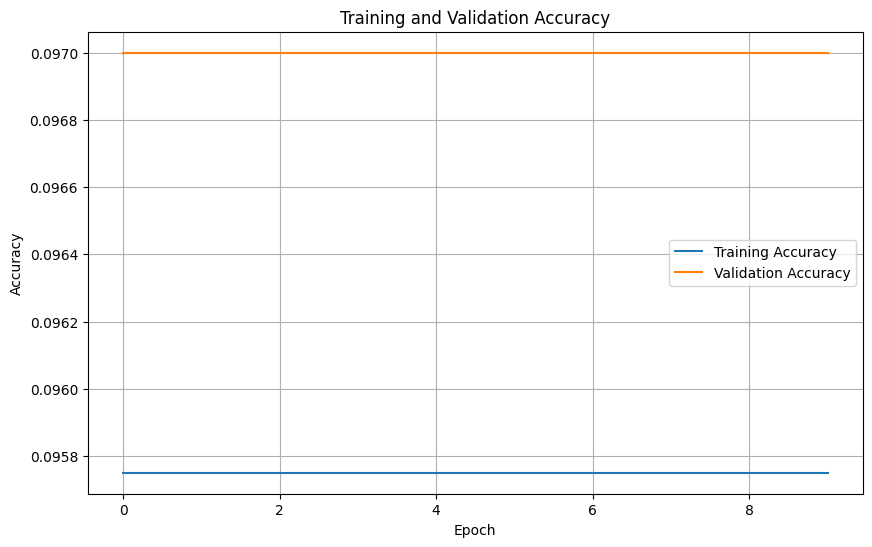

Test Accuracy: 9.70%


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

# ডেটা লোড ও প্রিপারেশন (উদাহরণস্বরূপ CIFAR-10)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
NUM_CLASSES = 10
INPUT_IMG_SIZE = 224 # NASNetMobile এর জন্য একটি সাধারণ ইনপুট সাইজ

# NASNetMobile প্রি-ট্রেইনড মডেল লোড (ট্রান্সফার লার্নিং)
base_model = NASNetMobile(
    input_shape=(32, 32, 3), # CIFAR-10 এর সাইজ
    include_top=False,
    weights='imagenet'
)

# CIFAR-10 এর 32x32 ছবিকে NASNetMobile এর 224x224 সাইজের সাথে মেলাতে রিসাইজিং লেয়ার প্রয়োজন
def build_model(num_classes, input_image_size):
    inputs = tf.keras.Input(shape=(32, 32, 3))
    # Resizing to NASNetMobile's required input size (224, 224)
    x = tf.keras.layers.Resizing(input_image_size, input_image_size)(inputs)

    # NASNetMobile বেস মডেল
    base_model = NASNetMobile(
        input_shape=(input_image_size, input_image_size, 3),
        include_top=False,
        weights='imagenet'
    )(x)

    # কাস্টম টপ লেয়ার যোগ করা
    x = GlobalAveragePooling2D()(base_model)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    # বেস মডেলের ওয়েট ফ্রীজ করা (প্রথমদিকে)
    model.trainable = False

    return model

model = build_model(NUM_CLASSES, INPUT_IMG_SIZE)

# মডেল কম্পাইল
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# মডেল ট্রেনিং
history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2 # ট্রেনিং থেকে ভ্যালিডেশন ডেটা ভাগ
)

# --- অ্যাক্যুরেসি প্লট ---
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()


# --- টেস্টিং অ্যাক্যুরেসি ইভ্যালুয়েশন ---
loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

In [3]:
# Add checks here to see if the directories were created after running cell 5gDn5L7UuMC8
import os

# --- GLOBAL VARIABLES (ensure these match your setup) ---
# Define the directory paths here as they might not be available in this cell's scope
TRAIN_DATA_ROOT = "/content/drive/MyDrive/yolo/MosquitoFusion Dataset/train"
VALID_FIXED_DIR = "/content/drive/MyDrive/yolo/MosquitoFusion Dataset/valid"
TEST_FIXED_DIR = "/content/drive/MyDrive/yolo/MosquitoFusion Dataset/test"
# ------------------------


expected_dirs = [
    TRAIN_DATA_ROOT,
    VALID_FIXED_DIR,
    TEST_FIXED_DIR
]

print("\n--- Verifying Output Directories ---")
for dir_path in expected_dirs:
    if os.path.exists(dir_path):
        print(f"Directory exists: {dir_path}")
        # Optionally, check if it's not empty
        if not os.listdir(dir_path):
            print(f"Warning: Directory is empty: {dir_path}")
    else:
        print(f"Error: Directory does not exist: {dir_path}")

print("--- Directory Verification Complete ---")


--- Verifying Output Directories ---
Error: Directory does not exist: /content/drive/MyDrive/yolo/MosquitoFusion Dataset/train
Error: Directory does not exist: /content/drive/MyDrive/yolo/MosquitoFusion Dataset/valid
Error: Directory does not exist: /content/drive/MyDrive/yolo/MosquitoFusion Dataset/test
--- Directory Verification Complete ---


In [ ]:
from google.colab import drive
drive.mount('/content/drive')